In [2]:
# @title 1. Instalación de SpaCy y Modelos
!pip install -U spacy --quiet
!python -m spacy download en_core_web_sm --quiet

import spacy
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report

SEMILLA = 111014

# Cargar el modelo de lenguaje
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

URL_BASE = '/kaggle/input/nlp-getting-started/'

df_train = pd.read_csv(URL_BASE + "train.csv")
df_test  = pd.read_csv(URL_BASE + "test.csv")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [3]:
# @title 2. Creación de Features y Limpieza

def limpiar_y_lemmatizar(text):
    # 1. Normalización básica
    text = str(text).lower()
    # 2. Usamos spaCy para tokenizar y lemmatizar
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct and not token.is_space]
    return " ".join(tokens)

def generar_meta_features(df):
    df = df.copy()

    df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
    df['char_count'] = df['text'].apply(lambda x: len(str(x)))
    df['mean_word_len'] = df['char_count'] / (df['word_count'] + 1)

    df['punct_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in '!?']))
    df['caps_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c.isupper()]))
    df['caps_ratio'] = df['caps_count'] / (df['char_count'] + 1)

    df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
    df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
    df['has_url'] = df['text'].apply(lambda x: 1 if 'http' in str(x) else 0)

    return df

df_enriched = generar_meta_features(df_train)

df_enriched['text_clean'] = df_enriched['text'].apply(limpiar_y_lemmatizar)

df_enriched[['text', 'text_clean', 'word_count', 'caps_ratio', 'has_url']].head()

,text,text_clean,word_count,caps_ratio,has_url
0,Our Deeds are the Reason of this #earthquake M...,deed reason earthquake allah forgive,13,0.142857,0
1,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,7,0.128205,0
2,All residents asked to 'shelter in place' are ...,resident ask shelter place notify officer evac...,22,0.014925,0
3,"13,000 people receive #wildfires evacuation or...","13,000 people receive wildfire evacuation orde...",8,0.015152,0
4,Just got sent this photo from Ruby #Alaska as ...,get send photo ruby alaska smoke wildfire pour...,16,0.033708,0


In [5]:
df_enriched.head()

,id,keyword,location,text,target,word_count,char_count,mean_word_len,punct_count,caps_count,caps_ratio,hashtag_count,mention_count,has_url,text_clean
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,69,4.928571,0,10,0.142857,1,0,0,deed reason earthquake allah forgive
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,38,4.750000,0,5,0.128205,0,0,0,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,133,5.782609,0,2,0.014925,0,0,0,resident ask shelter place notify officer evac...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,65,7.222222,0,1,0.015152,1,0,0,"13,000 people receive wildfire evacuation orde..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,88,5.176471,0,3,0.033708,2,0,0,get send photo ruby alaska smoke wildfire pour...


In [7]:
# @title 3. Split

X = df_enriched.drop(['target', 'text', 'text_clean'], axis=1)
y = df_enriched['target']

# Usamos stratify para mantener el balance de clases
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=SEMILLA, stratify=y
)

text_train = df_enriched.loc[X_train_raw.index, 'text_clean']
text_val = df_enriched.loc[X_val_raw.index, 'text_clean']

In [8]:
# @title

# Lleno los Nans
X_train_raw['keyword'] = X_train_raw['keyword'].fillna('no_keyword')
X_val_raw['keyword'] = X_val_raw['keyword'].fillna('no_keyword')

stats = y_train.groupby(X_train_raw['keyword']).agg(['count', 'mean'])
counts = stats['count']
means = stats['mean']
global_mean = y_train.mean()
m = 10 # Suavizado

smooth_map = (counts * means + m * global_mean) / (counts + m)

# Aplicamos el mapa aprendido en Train a ambos sets
X_train_raw['keyword_encoded'] = X_train_raw['keyword'].map(smooth_map).fillna(global_mean)
# Si en validación aparece una keyword nueva, se rellena con el promedio global de train
X_val_raw['keyword_encoded'] = X_val_raw['keyword'].map(smooth_map).fillna(global_mean)

In [10]:
smooth_map

,0
keyword,
ablaze,0.386411
accident,0.634819
aftershock,0.104810
airplane%20accident,0.714624
ambulance,0.495054
...,...
wounded,0.683708
wounds,0.332357
wreck,0.282430


In [ ]:
# @title Encodings

from sklearn.preprocessing import OneHotEncoder

X_train_raw['length_type'] = pd.cut(X_train_raw['word_count'], bins=[-1, 10, 20, 100], labels=['Short', 'Medium', 'Long'])
X_val_raw['length_type'] = pd.cut(X_val_raw['word_count'], bins=[-1, 10, 20, 100], labels=['Short', 'Medium', 'Long'])

ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
length_ohe_train = ohe.fit_transform(X_train_raw[['length_type']])
length_ohe_val = ohe.transform(X_val_raw[['length_type']])

ohe_cols = ohe.get_feature_names_out(['length_type'])
df_ohe_train = pd.DataFrame(length_ohe_train, columns=ohe_cols, index=X_train_raw.index)
df_ohe_val = pd.DataFrame(length_ohe_val, columns=ohe_cols, index=X_val_raw.index)


# TF-IDF
tfidf = TfidfVectorizer(max_features=3000, min_df=3, ngram_range=(1, 1))
tfidf_train = tfidf.fit_transform(text_train).toarray()
tfidf_val = tfidf.transform(text_val).toarray()

df_tfidf_train = pd.DataFrame(tfidf_train, columns=tfidf.get_feature_names_out(), index=X_train_raw.index)
df_tfidf_val = pd.DataFrame(tfidf_val, columns=tfidf.get_feature_names_out(), index=X_val_raw.index)

numeric_cols = ['word_count', 'char_count', 'mean_word_len', 'punct_count',
                'caps_count', 'caps_ratio', 'hashtag_count', 'mention_count', 'has_url', 'keyword_encoded']

X_train_final = pd.concat([X_train_raw[numeric_cols], df_ohe_train, df_tfidf_train], axis=1)
X_val_final = pd.concat([X_val_raw[numeric_cols], df_ohe_val, df_tfidf_val], axis=1)

In [ ]:

# @title Entrenamiento base y validacion base

xgb_model = xgb.XGBClassifier(
    n_estimators=3000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.3,
    colsample_bytree=0.8,
    scale_pos_weight=1,
    random_state=SEMILLA,
    n_jobs=-1
)

xgb_model.fit(X_train_final, y_train)

y_pred = xgb_model.predict(X_val_final)
print(classification_report(y_val, y_pred))
print(f"F1 Score: {f1_score(y_val, y_pred):.4f}")



              precision    recall  f1-score   support

           0       0.81      0.83      0.82       869
           1       0.77      0.74      0.75       654

    accuracy                           0.79      1523
   macro avg       0.79      0.79      0.79      1523
weighted avg       0.79      0.79      0.79      1523

F1 Score: 0.7535


In [ ]:
# @title Metricas de evaluacion sin Tunning de hiperparametros

from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

print("Metricas de evaluacion sin Tunning de hiperparametros")

# F1
from sklearn.metrics import f1_score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f'F1: {f1}')

# La accuracy es una metrica que se mide en:
#Cantidad de aciertos / Totales
# Usando 0.5 de umbral
accuracy = accuracy_score(y_val, y_pred)

# La precision es una metrica que se mide en:
# Cuantos Desastres predichos son de verdad desastres
# (Cantidad de 1s correctos / Cantidad de 1s) o lo mismo pero con los 0s
precision_1 = precision_score(y_val, y_pred, pos_label=1)
precision_0 = precision_score(y_val, y_pred, pos_label=0)

# Es el Analogo de la Precision:
# Recall: Cuantos de los que son de una clase predije como de esa clase?
# 1s Recuperados / Cantidad total de 1s

recall_1 = recall_score(y_val, y_pred, pos_label=1)
recall_0 = recall_score(y_val, y_pred, pos_label=0)

print("Accuracy:", accuracy)
print("Precision_0:", precision_0)
print("Precision_1:", precision_1)
print("Recall_0:", recall_0)
print("Recall_1:", recall_1)

Metricas de evaluacion sin Tunning de hiperparametros
F1: 0.7919398752535878
Accuracy: 0.7925147734734077
Precision_0: 0.8089385474860336
Precision_1: 0.7691082802547771
Recall_0: 0.8331415420023015
Recall_1: 0.7385321100917431


In [ ]:
# @title Busqueda de hiperparametros optimos con RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [300, 800, 2000],
    'learning_rate': [0.02, 0.04, 0.1],
    'max_depth': [2, 4, 8],
    'min_child_weight': [3, 5, 7],
    'gamma': [0.1, 0.5],
    'scale_pos_weight': [1, 1.3, 1.6, 1.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.2, 0.4]
}

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=25,
    scoring='f1',
    cv=4,
    verbose=2,
    random_state=SEMILLA,
    n_jobs=-1
)

random_search.fit(X_train_final, y_train)


best_model = random_search.best_estimator_
y_pred_opt = best_model.predict(X_val_final)


Fitting 4 folds for each of 25 candidates, totalling 100 fits


In [ ]:
# @title Metricas de evaluacion

from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# F1
from sklearn.metrics import f1_score
f1 = f1_score(y_val, y_pred_opt, average='weighted')
print(f'F1: {f1}')

# La accuracy es una metrica que se mide en:
#Cantidad de aciertos / Totales
# Usando 0.5 de umbral
accuracy = accuracy_score(y_val, y_pred_opt)

# La precision es una metrica que se mide en:
# Cuantos Desastres predichos son de verdad desastres
# (Cantidad de 1s correctos / Cantidad de 1s) o lo mismo pero con los 0s
precision_1 = precision_score(y_val, y_pred_opt, pos_label=1)
precision_0 = precision_score(y_val, y_pred_opt, pos_label=0)

# Es el Analogo de la Precision:
# Recall: Cuantos de los que son de una clase predije como de esa clase?
# 1s Recuperados / Cantidad total de 1s

recall_1 = recall_score(y_val, y_pred_opt, pos_label=1)
recall_0 = recall_score(y_val, y_pred_opt, pos_label=0)

print(f'F1: {f1}')
print("Accuracy:", accuracy)
print("Precision_0:", precision_0)
print("Precision_1:", precision_1)
print("Recall_0:", recall_0)
print("Recall_1:", recall_1)

F1: 0.7843489974356977
F1: 0.7843489974356977
Accuracy: 0.783322390019698
Precision_0: 0.8424396442185514
Precision_1: 0.720108695652174
Recall_0: 0.762945914844649
Recall_1: 0.8103975535168195


In [ ]:
# @title Metricas de evaluacion

from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)

# F1
from sklearn.metrics import f1_score
f1 = f1_score(y_val, y_pred_opt, average='weighted')
print(f'F1: {f1}')

# La accuracy es una metrica que se mide en:
#Cantidad de aciertos / Totales
# Usando 0.5 de umbral
accuracy = accuracy_score(y_val, y_pred_opt)

# La precision es una metrica que se mide en:
# Cuantos Desastres predichos son de verdad desastres
# (Cantidad de 1s correctos / Cantidad de 1s) o lo mismo pero con los 0s
precision_1 = precision_score(y_val, y_pred_opt, pos_label=1)
precision_0 = precision_score(y_val, y_pred_opt, pos_label=0)

# Es el Analogo de la Precision:
# Recall: Cuantos de los que son de una clase predije como de esa clase?
# 1s Recuperados / Cantidad total de 1s

recall_1 = recall_score(y_val, y_pred_opt, pos_label=1)
recall_0 = recall_score(y_val, y_pred_opt, pos_label=0)

print(f'F1: {f1}')
print("Accuracy:", accuracy)
print("Precision_0:", precision_0)
print("Precision_1:", precision_1)
print("Recall_0:", recall_0)
print("Recall_1:", recall_1)

F1: 0.783657999740354
F1: 0.783657999740354
Accuracy: 0.7826657912015759
Precision_0: 0.8387909319899244
Precision_1: 0.7215363511659808
Recall_0: 0.766398158803222
Recall_1: 0.8042813455657493


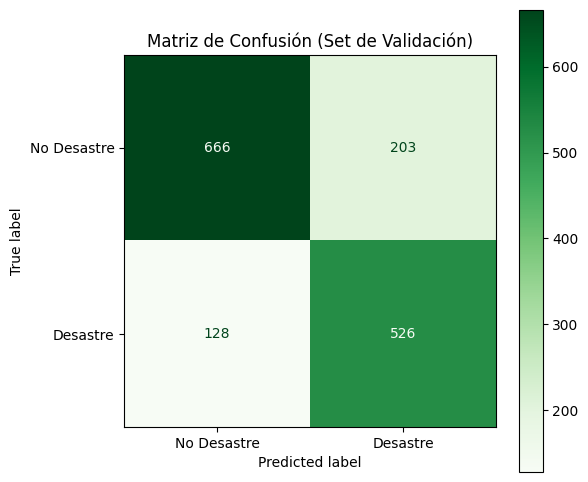

In [ ]:
# @title Matriz de Confusion Parte 4
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

f1_val = f1_score(y_val, y_pred_opt, average='weighted')
LEGEND_LABELS = ['No Desastre', 'Desastre']

fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_val_final,
    y_val,
    display_labels=LEGEND_LABELS,
    cmap='Greens',
    ax=ax
)
plt.title('Matriz de Confusión (Set de Validación)')
plt.show()


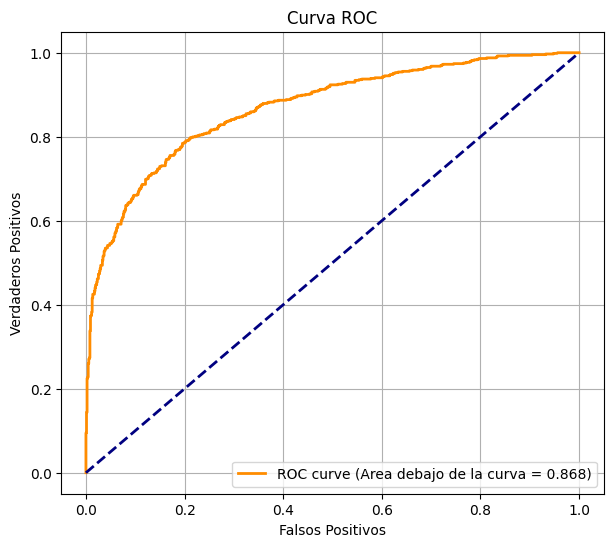

In [ ]:
# @title Curva ROC
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_val_proba = best_model.predict_proba(X_val_final)[:, 1]

fpr, tpr, thresholds = roc_curve(y_val, y_val_proba)
roc_auc = roc_auc_score(y_val, y_val_proba)

# Graficar
plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (Area debajo de la curva = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Modelo Random
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()